In [1]:
# Generate data for long only portfolio optimization.
srand(9);
n = 10;
mu = abs(randn(n, 1));
Sigma = randn(n, n);
Sigma = Sigma' * Sigma;

In [2]:
# Long only portfolio optimization.
using Convex, SCS, ECOS
set_default_solver(SCSSolver(verbose=0));
w = Variable(n);
ret = sum(mu' * w);
risk = sum(quad_form(w, Sigma));

# Compute trade-off curve.
SAMPLES = 100;
risk_data = zeros(SAMPLES);
ret_data = zeros(SAMPLES);
gamma_vals = logspace(-2, 3, SAMPLES);
for i=1:SAMPLES
    gamma = gamma_vals[i];
    problem = maximize(ret - gamma*risk, [sum(w) == 1, w >= 0]);
    solve!(problem);
    risk_data[i] = sqrt(evaluate(risk));
    ret_data[i] = evaluate(ret);
end

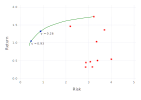

In [3]:
using Gadfly
markers_on = [29, 40];
labels = [@sprintf("γ = %0.2f", gamma_vals[marker]) for marker in markers_on];
plot(
layer(x=[sqrt(Sigma[i,i]) for i=1:n], y=mu,
        Geom.point, Theme(default_color=color("red"))),
layer(x=risk_data, y=ret_data,
        Geom.line, Theme(default_color=color("green"))),
layer(x=risk_data[markers_on], y=ret_data[markers_on], label=labels,
        Geom.point, Geom.label, Theme(default_color=color("blue"))),
Guide.XLabel("Risk"), Guide.YLabel("Return")
)

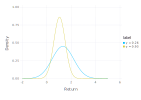

In [4]:
# Plot return distributions for two points on the trade-off curve.
using DataFrames, Distributions
xdata = linspace(-2, 5, 1000);
df = DataFrame(x=xdata,
    y=pdf(Normal(ret_data[markers_on[1]], risk_data[markers_on[1]]), xdata),
    label=@sprintf("γ = %0.2f", gamma_vals[markers_on[1]]));
for i=2:length(markers_on)
    m = markers_on[i];
    df = vcat(df, DataFrame(x=xdata,
                    y=pdf(Normal(ret_data[m], risk_data[m]), xdata),
                    label=@sprintf("γ = %0.2f", gamma_vals[m])));
end
plot(df, x="x", y="y", color="label", Geom.line, Guide.XLabel("Return"), Guide.YLabel("Density"))

In [ ]:
# Portfolio optimization with leverage limit.
# Compute trade-off curve for each leverage limit.
L_vals = [1, 2, 4];
SAMPLES = 100;
risk_data = zeros(length(L_vals), SAMPLES);
ret_data = zeros(length(L_vals), SAMPLES);
for k=1:length(L_vals)
    for i=1:SAMPLES
        Lmax = L_vals[k];
        gamma = gamma_vals[i];
        problem = maximize(ret - gamma*risk,[sum(w) == 1, norm(w, 1) <= Lmax]);
        solve!(problem);
        risk_data[k, i] = sqrt(evaluate(risk));
        ret_data[k, i] = evaluate(ret);
    end
end

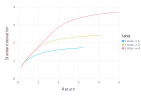

In [6]:
df = DataFrame(x=vec(risk_data[1,:]), y=vec(ret_data[1,:]), label=@sprintf("Lmax = %d", L_vals[1]));
for i=2:length(L_vals)
    df = vcat(df, DataFrame(x=vec(risk_data[i,:]), y=vec(ret_data[i,:]), label=@sprintf("Lmax = %d", L_vals[i])));
end
plot(df, x="x", y="y", color="label", Geom.line, Guide.XLabel("Return"), Guide.YLabel("Standard deviation"))

In [7]:
# Portfolio optimization with a leverage limit and a bound on risk.
# Compute solution for different leverage limits.
w_vals = zeros(n, length(L_vals));
for i=1:length(L_vals)
    problem = maximize(ret, [sum(w) == 1, norm(w, 1) <= L_vals[i], risk <= 2]);
    solve!(problem);
    w_vals[:, i] = evaluate(w);
end

In [8]:
# Generate data for factor model.
n = 3000;
m = 50;
mu = abs(randn(n, 1));
Sigma_tilde = randn(m, m);
Sigma_tilde = Sigma_tilde' * Sigma_tilde;
D = diagm(0.9 * rand(n));
F = randn(n, m);

In [9]:
# Factor model portfolio optimization.
w = Variable(n);
f = F' * w;
ret = sum(mu' * w); 
risk = quad_form(f, Sigma_tilde) + quad_form(w, D);


# Solve the factor model problem.
Lmax = 2
gamma = 0.1
factor_problem = maximize(ret - gamma*risk, [sum(w) == 1, norm(w, 1) <= Lmax]);
solve!(factor_problem, ECOSSolver())


ECOS 1.0.5 - (c) A. Domahidi, ETH Zurich & embotech 2012-14. Support: ecos@embotech.com

It     pcost         dcost      gap     pres    dres     k/t     mu      step     IR
 0   -7.928e-01   -1.279e+01   +2e+04   3e+01   1e+02   1e+00   3e+00    N/A     4 5 -
 1   -1.139e+01   -1.274e+01   +2e+03   4e+00   1e+01   4e-01   4e-01   0.9899   4 3 4
 2   -7.570e+00   -7.792e+00   +4e+02   6e-01   2e+00   2e-02   7e-02   0.8105   3 3 3
 3   -7.340e+00   -7.529e+00   +4e+02   5e-01   2e+00   2e-02   6e-02   0.2022   4 4 4
 4   -6.937e+00   -7.099e+00   +4e+02   4e-01   1e+00   2e-02   6e-02   0.2089   5 4 5
 5   -6.565e+00   -6.694e+00   +3e+02   3e-01   1e+00   2e-02   5e-02   0.2735   4 4 4
 6   -5.876e+00   -5.948e+00   +2e+02   2e-01   7e-01   1e-02   3e-02   0.5625   5 5 5
 7   -5.533e+00   -5.582e+00   +2e+02   1e-01   4e-01   8e-03   3e-02   0.3618   5 5 5
 8   -5.313e+00   -5.348e+00   +1e+02   1e-01   3e-01   5e-03   2e-02   0.4704   5 5 5
 9   -4.961e+00   -4.975e+00   +5e+01   4e

In [10]:
# Standard portfolio optimization with data from factor model.
risk = quad_form(w, F * Sigma_tilde * F' + D);
problem = maximize(ret - gamma*risk,  [sum(w) == 1, norm(w, 1) <= Lmax]);

In [ ]:
# Warning: This takes a long time.
# solve!(problem, ECOSSolver())